# Plot fitting STF

We plot the fitting of the STF.

2024.11.28 Kurama Okubo

- 2025.2.12 Update for the master plot of fitting STF

In [41]:
import os
import obspy
from obspy import read, Stream, Trace
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
import glob
from glob import glob
import numpy as np
import mpmath as mp
import pandas as pd
import datetime
from datetime import timedelta
from tqdm import tqdm
import warnings

from matplotlib import gridspec

from scipy import interpolate
from scipy.optimize import curve_fit  
import matplotlib as mpl
import pickle
import copy

import seaborn as sns 
from scipy.interpolate import LSQUnivariateSpline
from scipy import integrate
from scipy.interpolate import CubicSpline

import h5py # store the STF in hdf5
from scipy.optimize import minimize

from STFfit_func import *

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 10
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True

plt.rcParams["savefig.transparent"] = True
plt.rcParams['axes.linewidth'] = 0.75

from obspy.core.utcdatetime import UTCDateTime  
os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion
UTCDateTime.DEFAULT_PRECISION = 8

In [42]:
dataoutdir = "../data/06_plotSTFfit/"
if not os.path.exists(dataoutdir):
    os.makedirs(dataoutdir)

In [43]:
figdir = "../figure/06_plotSTFfit/"
if not os.path.exists(figdir):
    os.makedirs(figdir)

# Read the STF

In [44]:
gougepatch_id = "G3" # to set output filename
denoise_method = "detrend"
Qinv_quart = 50
k_waterlevel = 0.3

fo = h5py.File(f"../data/03_computePdisp/STF_all_{gougepatch_id}_Q{Qinv_quart}_wlv_{k_waterlevel:.2f}_denoisemethod_{denoise_method.lower()}.hdf5", 'r+')


In [45]:
# selected AE sensors for patch G3
AEsensor_list = ["OL23", "OL07", "OL08", "OL22"] # update: we use 4 close sensors "OL24"] 

In [46]:
tvec = np.array(fo[f"param/tvec_upsampled_margintrimmed"])

# pwin_pre = fo[f"param"].attrs["pwin_pre"]
dt_upsampled = fo[f"param"].attrs["dt_upsampled"]
pwin_pre = fo[f"param"].attrs["pwin_pre"]
pwin_len = fo[f"param"].attrs["pwin_len"] 
k_waterlevel = fo[f"param"].attrs["k_waterlevel"] 


In [47]:
fo[f"param"].attrs.keys()

<KeysViewHDF5 ['NFFT', 'denoise_method', 'dt_upsampled', 'k_waterlevel', 'polyfit_Rcontinu_buffer', 'polyfit_smooth_lowpass_freqmax', 'polyfit_winlens', 'polyords', 'pwin_len', 'pwin_pre', 'trim_margin']>

In [48]:
datacases = list(fo.keys())
datacases.remove("param")
# datacases


# Read stats of source parameters

In [49]:
expr_id = 87
foname_all = f"../data/05_STFstats/SourceParam_allsensors_fb03-{expr_id:03d}_{gougepatch_id}_wlv_{k_waterlevel:.2f}_denoisemethod_{denoise_method.lower()}.csv"
df_sourceparam = pd.read_csv(foname_all, index_col=0)

foname_mean = f"../data/05_STFstats/SourceParam_meanstd_fb03-{expr_id:03d}_{gougepatch_id}_wlv_{k_waterlevel:.2f}_denoisemethod_{denoise_method.lower()}.csv"
df_stats = pd.read_csv(foname_mean, index_col=0)

# Plot the comparison of the synthetic and the observed STF

In [50]:
df_stats.head()

,datacase,gougeevent_id,Qinv_quart,Nvalidsensors,M0_mean,M0_std,Tw_mean,Tw_std
index,,,,,,,,
fb03-087,fb03-087__0004,4,50,4,0.594031,0.179160,0.000003,1.516442e-07
fb03-087,fb03-087__0009,9,50,4,0.047135,0.007497,0.000002,3.630314e-07
fb03-087,fb03-087__0018,18,50,4,0.757592,0.193624,0.000003,3.109912e-07
fb03-087,fb03-087__0019,19,50,4,0.056071,0.017249,0.000002,2.699614e-07
fb03-087,fb03-087__0020,20,50,4,0.867075,0.209970,0.000003,1.379112e-07


# Plot the fitting of STF for master plot

We synchronize the scale in displacement and the panel size.

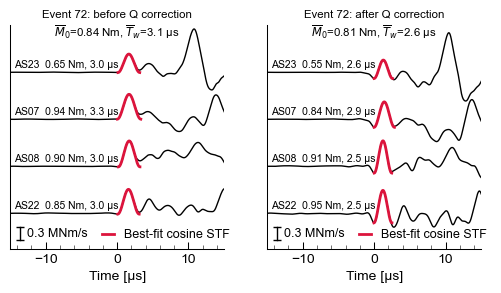

In [51]:
stf_type = "cosine"

Qindex_list = ["noQcorr", "Q50"] #"Q50"  # Q50

Nsensors_thresh = 4

yshift_span = 2

plot_tshift = 5e-6 #time shift to trim the edge effect of polynomial fitting

p_onset = pwin_pre - plot_tshift # zero at the onset of P

text_x = -14.5
annotfontsize = 7.5 #10.25

# datacase = datacases_sorted[23]
ploteventid = 72 # event ID to plot
datacase = f"fb03-087__{ploteventid:04d}"

fig, axs = plt.subplots(1, 2, figsize=(6.08, 2.9))

# synchronize the normalizing factor between the cases of noQcorr and Q50 by the former case

df_event_ampnorm = df_sourceparam[(df_sourceparam["datacase"]==datacase) & (df_sourceparam["Qinv_quart"]=="noQcorr") & (df_sourceparam["validflag"]==True)]
M0dot_ampnorm = df_event_ampnorm["peakSTFamp"].mean() # noramlize the moment rate function by the mean of estimated peak M0



for ii, Qindex in enumerate(Qindex_list):
    ax=axs[ii]

    # select the source parameters
    if Qindex == "noQcorr":
        Qinv_quart = Qindex
    else:
        Qinv_quart = int(Qindex[1:])


    df_event = df_sourceparam[(df_sourceparam["datacase"]==datacase) & (df_sourceparam["Qinv_quart"]==f"{Qinv_quart}") & (df_sourceparam["validflag"]==True)]
    df_stats_sensor = df_stats[(df_stats["datacase"]==datacase) & (df_stats["Qinv_quart"]==f"{Qinv_quart}")]
    assert len(df_stats_sensor) == 1 # assert if the row is correctly referred

    # M0dot_ampnorm = df_event["peakSTFamp"].mean() # noramlize the moment rate function by the mean of estimated peak M0

    yshift = 0
    
    for stnm in AEsensor_list:
        # stnm = AEsensor_list[2]
        
        gougeevent_id = int(datacase.split("__")[1])
        
        df_sensor = df_sourceparam[(df_sourceparam["datacase"]==datacase) & (df_sourceparam["AEsensor"]==int(stnm[2:])) & (df_sourceparam["Qinv_quart"]==f"{Qinv_quart}")]
        assert len(df_sensor) == 1 # assert if the row is correctly referred
    
        #-----------------------#
        # Plot the observed STF
        #-----------------------#
        STF_sensor = np.array(fo[f"{datacase}/{stnm}/{Qindex}/M0dot"])
    
        # remove the offset by the left edge
        offset_tind = np.where(tvec > plot_tshift)[0][0]
        offset_sensor = STF_sensor[offset_tind]
        
        ax.plot((tvec-plot_tshift- p_onset)*1e6, (STF_sensor-offset_sensor)/M0dot_ampnorm + yshift, "k-", lw=1)

        # read best-fit parameters
        M0_best = df_sensor["M0"].values[0]
        Tw_best = df_sensor["Tw"].values[0]
        tshift_best = df_sensor["Tshift"].values[0]
        stf_type_best = df_sensor["stf_type"].values[0]
        fitting_flag = df_sensor["fitting_flag"].values[0]
        error_fraction = df_sensor["error_fraction"].values[0]
        SNR_sensor = df_sensor["SNR_sensor"].values[0]
        validflag = df_sensor["validflag"].values[0]
    
        #-----------------------#
        # Plot synthesized STF
        #-----------------------#
        tvec_syn = np.linspace(0, Tw_best, int(Tw_best/dt_upsampled))
        STF_syn = eval("stf_"+stf_type_best+f"(tvec_syn, Tw_best, M0_best)")
    
        if validflag:
            ls = "-"
        else:
            ls = "--"
            
        h = ax.plot((pwin_pre - plot_tshift + tvec_syn - p_onset + tshift_best)*1e6, (STF_syn-offset_sensor)/M0dot_ampnorm + yshift, "crimson",
                lw=2.0, ls=ls)
    
        # annotate the sensors with the source parameters
        plottext = f"AS{stnm[2:]}  {M0_best:.2f} Nm, {Tw_best*1e6:.1f} μs"
    
        ax.text(text_x, yshift+0.1, plottext, va="bottom", fontsize=annotfontsize)
        yshift -= yshift_span
    
    # annot stats
    M0_mean = df_stats_sensor["M0_mean"].values[0]
    Tw_mean = df_stats_sensor["Tw_mean"].values[0]
    
    M0txt = r"$\overline{M}_0$"
    Twtxt = r"$\overline{T}_w$"
    
    if df_stats_sensor["Nvalidsensors"].values[0] >= Nsensors_thresh:
        if ii==0:
            statstext = f"Event {gougeevent_id:g}: before Q correction\n{M0txt}={M0_mean:.2f} Nm, {Twtxt}={Tw_mean*1e6:.1f} μs"
        else:
            statstext = f"Event {gougeevent_id:g}: after Q correction\n{M0txt}={M0_mean:.2f} Nm, {Twtxt}={Tw_mean*1e6:.1f} μs"

    else:
        statstext = f"event {gougeevent_id:g}: {M0txt}= N/A Nm, {Twtxt}= N/A μs"

    ax.text(0.5, 1.0, statstext, va="center", ha="center", fontsize=annotfontsize*1.1, transform=ax.transAxes)

    # axs[0].annotate('Best-fit cosine STF', xy=(2.4, -5.4), xytext=(0, -4.58),
    #                 arrowprops=dict(arrowstyle = '-', connectionstyle = 'arc3', facecolor='red'), 
    #                 horizontalalignment="left")

    # annotate the scale of moment rate function 
    scale_x1 = -13.6 # debug to fit the STF: 0
    scale_y1 = -6.87 # debug to fit the STF: -5.9
    scale_amplitude1 = 0.3e6 # 0.4; too large #[N/s]
    ax.plot([scale_x1, scale_x1], np.array([-scale_amplitude1/2, +scale_amplitude1/2])/M0dot_ampnorm+scale_y1, "k-",
            marker="_", lw=1);
    ax.text(scale_x1 + 1, -(scale_amplitude1/2/M0dot_ampnorm)+scale_y1+0.0, f"{scale_amplitude1/1e6:.1f} MNm/s",
            fontsize=annotfontsize*1.2, va="bottom")
    
    ax.spines[['right', 'top']].set_visible(False)

    ax.set_xlim([-15, 15])
    ax.set_ylim([-7.5, 2])
    ax.set_yticks([])
    
    ax.set_xlabel("Time [μs]")

    # plot legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(h, ["Best-fit cosine STF"], loc=4, frameon=False, handlelength=1.0, 
              borderaxespad=0, bbox_to_anchor=(1.05, 0.01),fontsize=annotfontsize*1.2)


plt.savefig(figdir + f"/STFfitPanelEvent_{gougepatch_id}_{gougeevent_id}_wlv_{k_waterlevel:.2f}_denoisemethod_{denoise_method.lower()}_master.png", dpi=150, bbox_inches="tight")
plt.savefig(figdir + f"/STFfitPanelEvent_{gougepatch_id}_{gougeevent_id}_wlv_{k_waterlevel:.2f}_denoisemethod_{denoise_method.lower()}_master.pdf", bbox_inches="tight")
plt.savefig(figdir + f"/STFfitPanelEvent_{gougepatch_id}_{gougeevent_id}_wlv_{k_waterlevel:.2f}_denoisemethod_{denoise_method.lower()}_master.eps", bbox_inches="tight")


In [52]:
M0dot_ampnorm

541194.1225

In [53]:
df_stats_sensor["Nvalidsensors"].values[0]

4

In [54]:
tshift_best

-3.12718054e-08

# Plot all the comparison with the panel

In [55]:
len(datacases)

44

In [56]:
# Sort the datacase by the magnitude
datacases_sorted = df_stats[df_stats["Qinv_quart"]==f"{Qinv_quart}"].sort_values(by="M0_mean").datacase.values


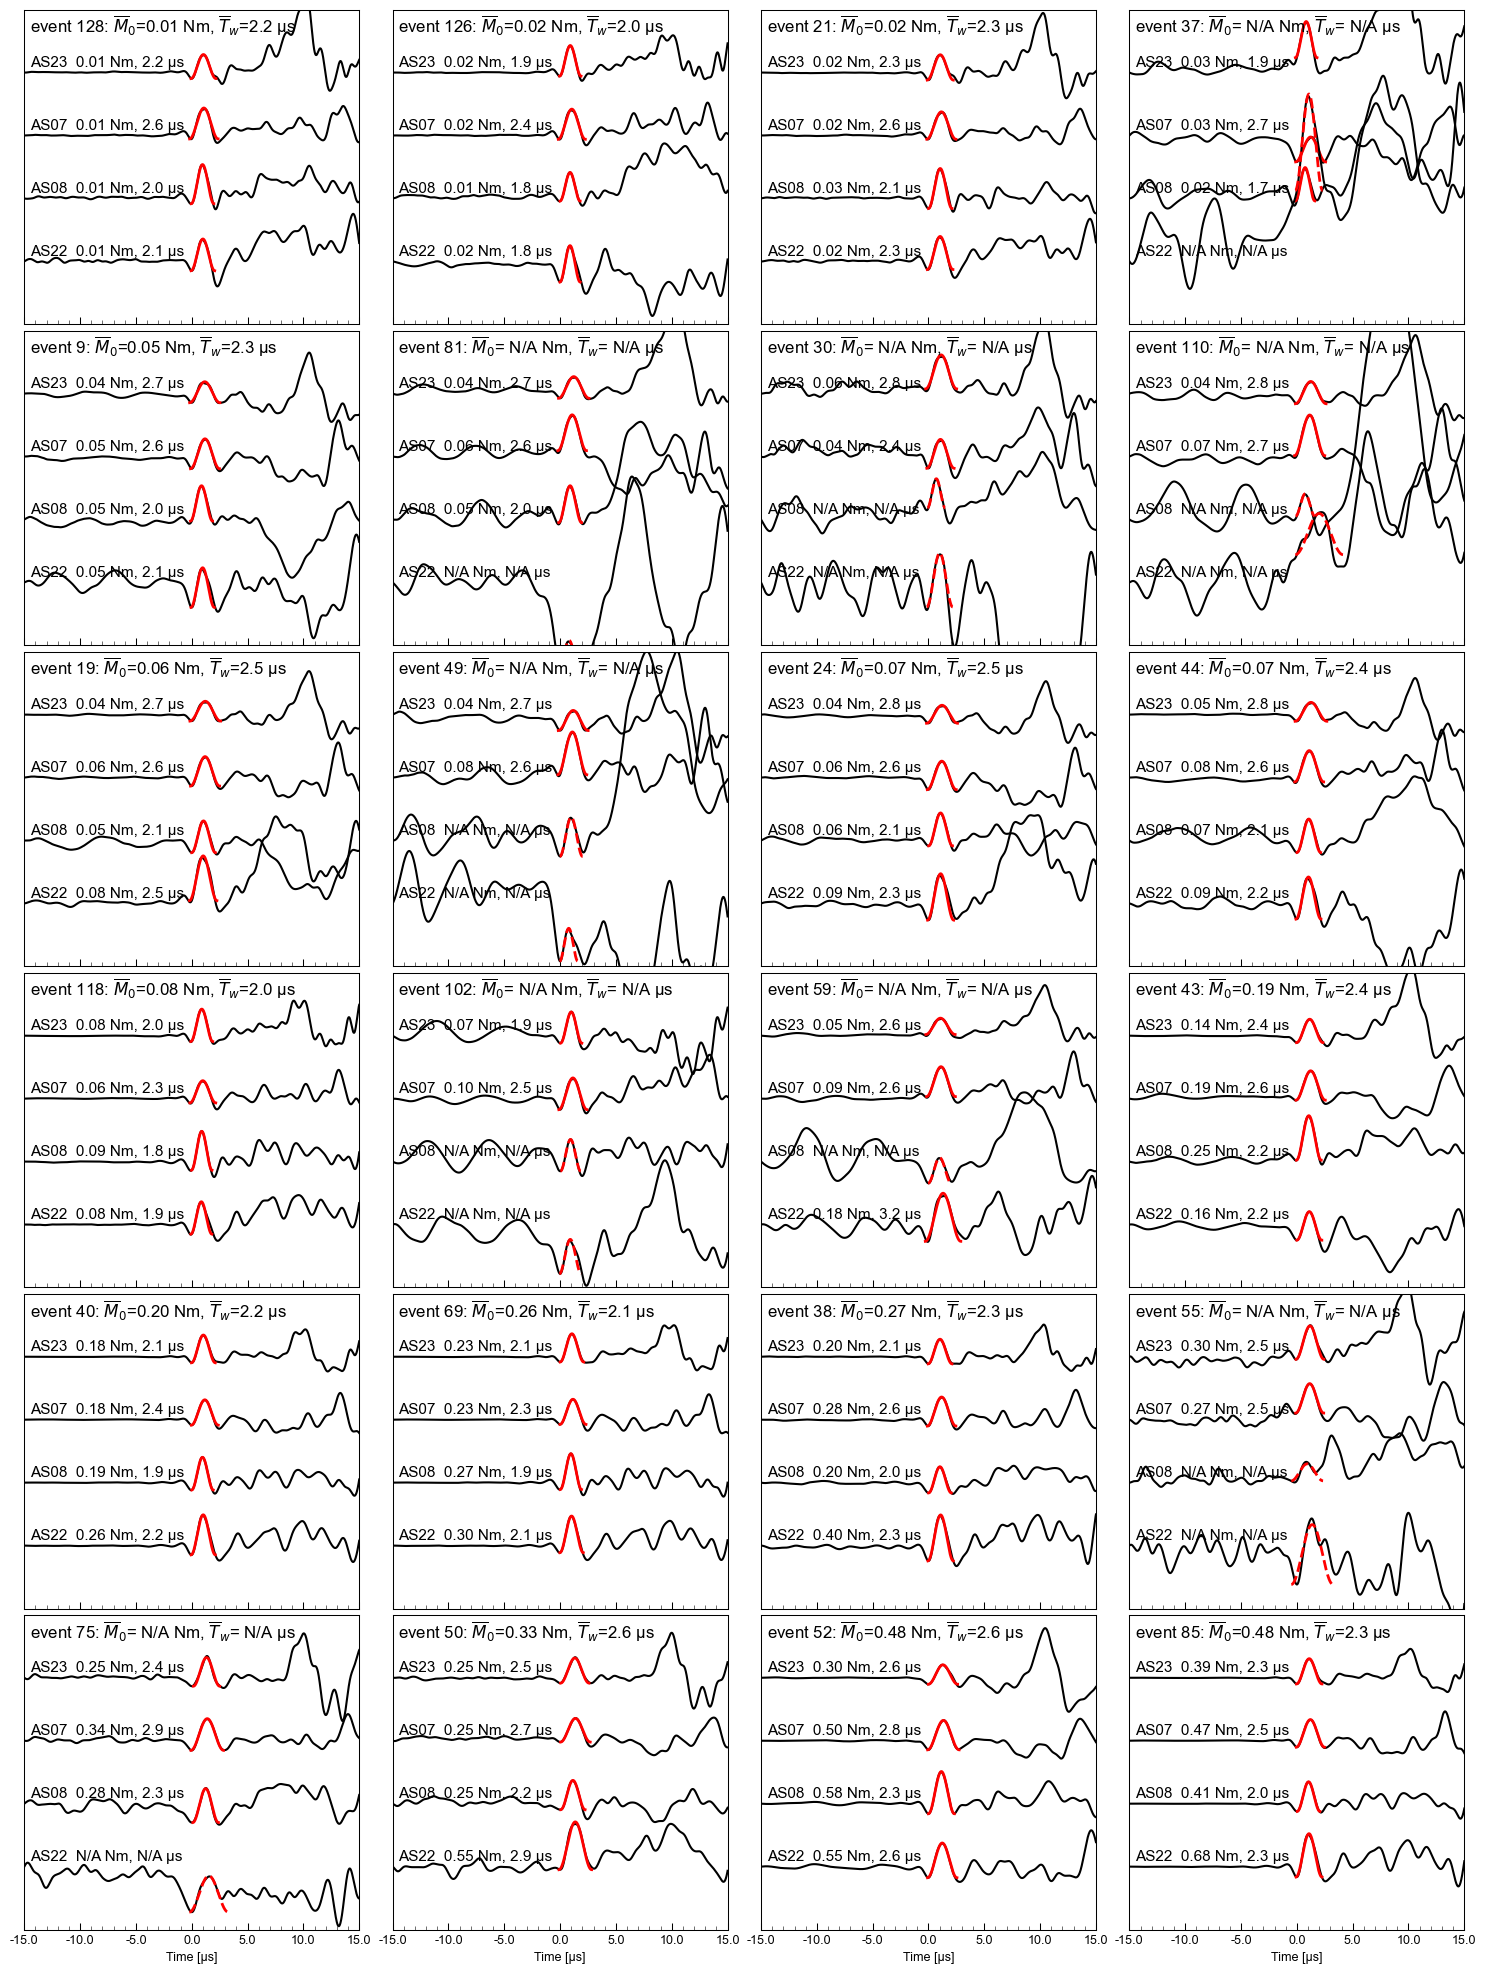

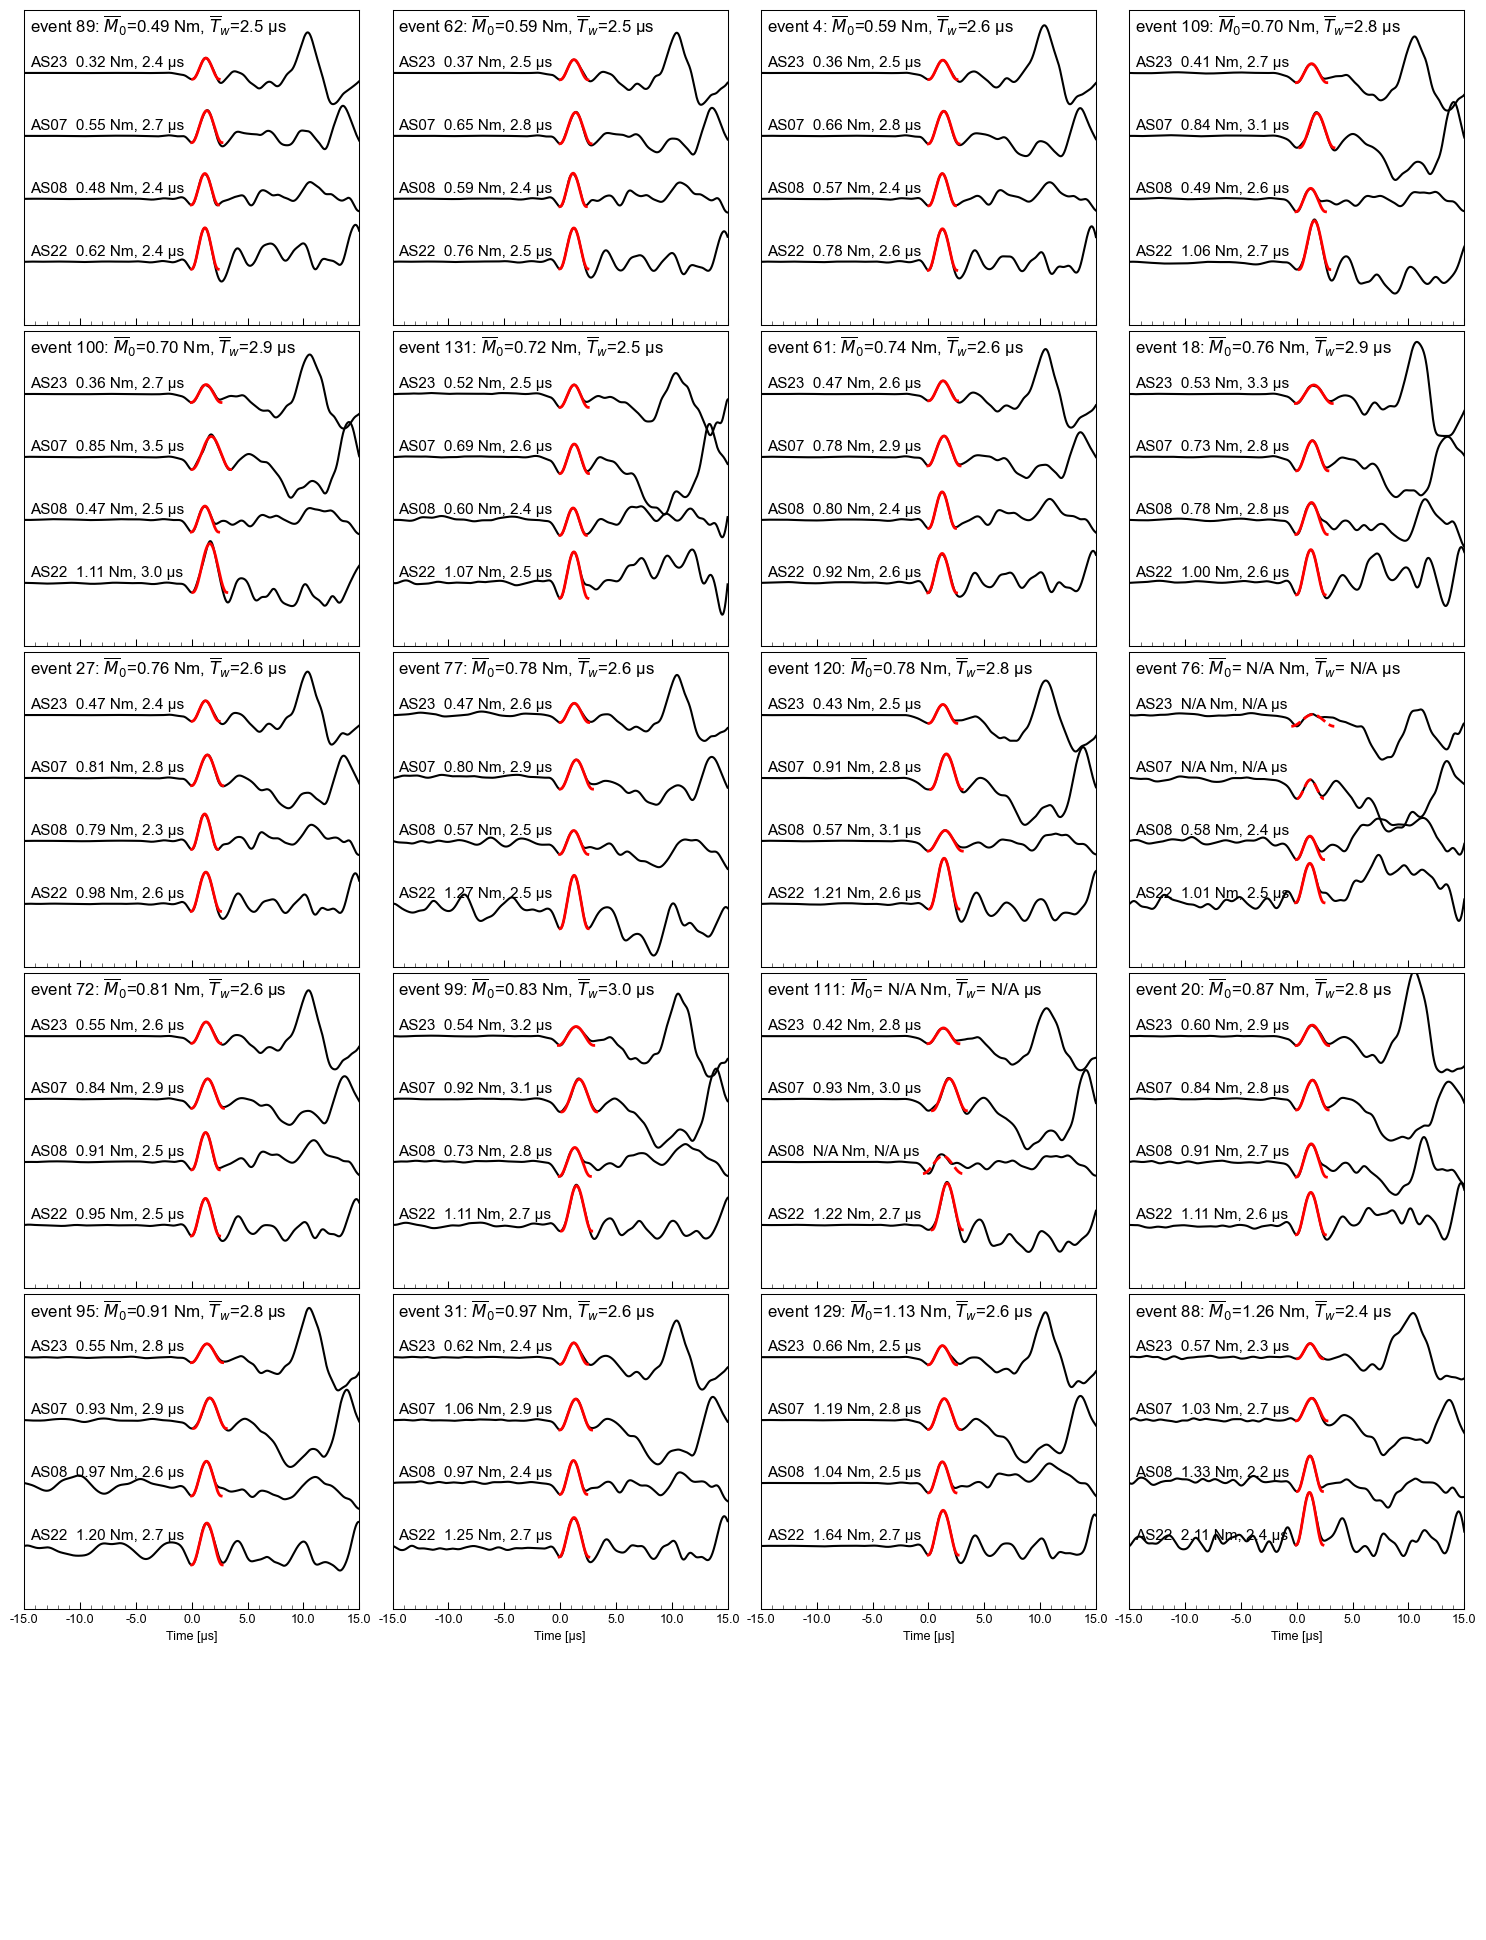

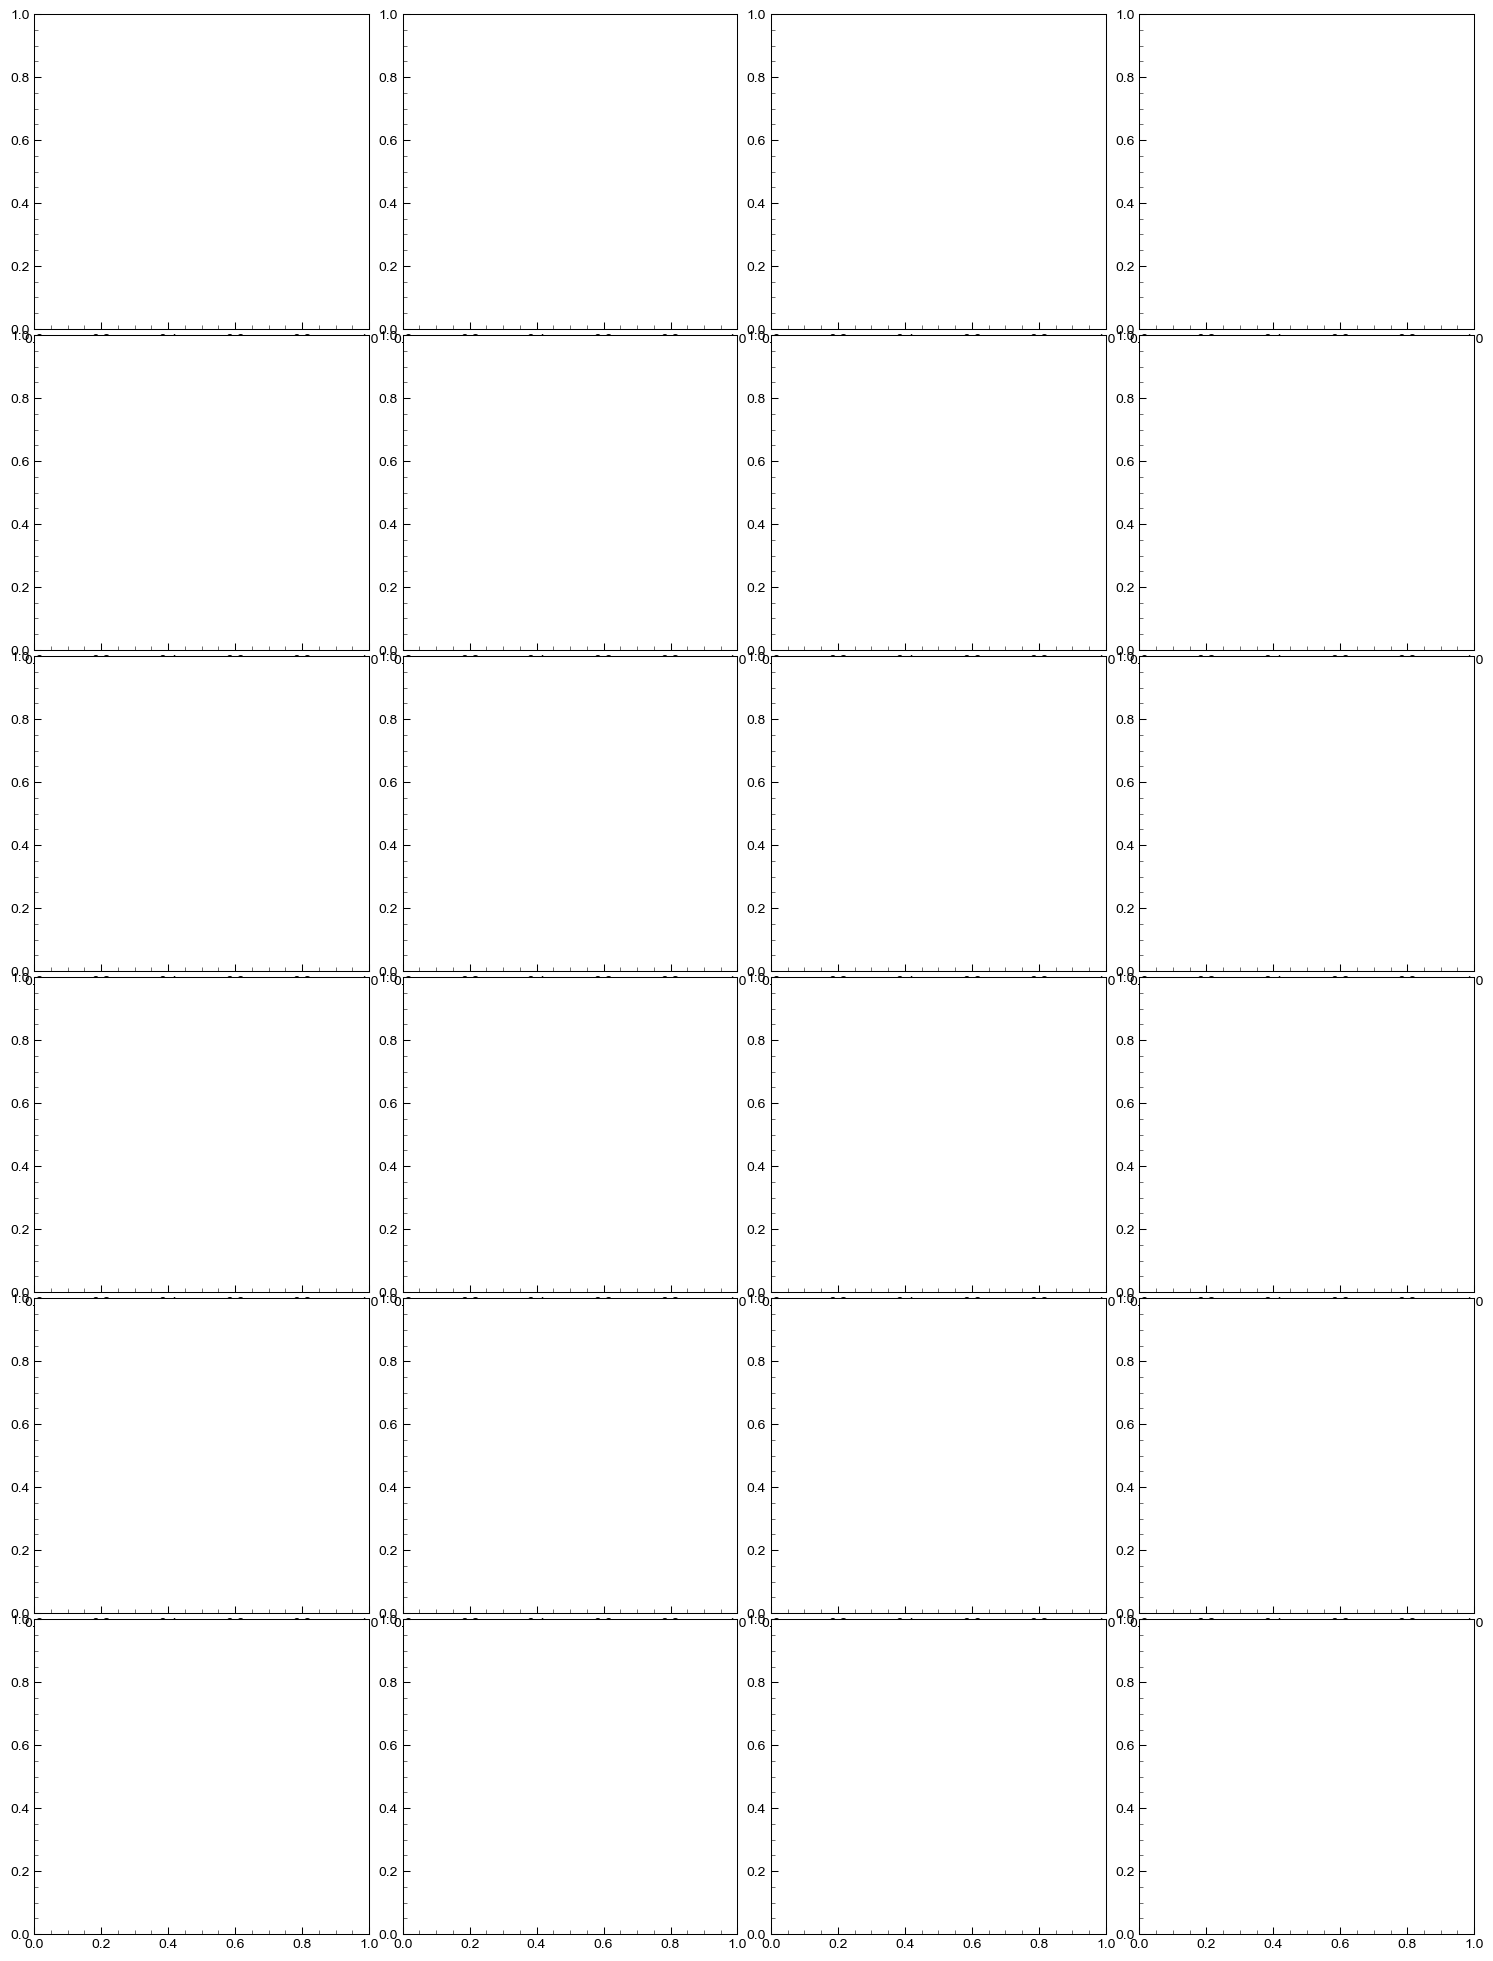

In [57]:
#----------------#
# Panel parameters
#----------------#
left=0.1
right=0.9
bottom=0.1
top=0.9
wspace=0.1
hspace=0.02

page_split_yrows = 6 #2
page_count = 0

Ndim_x = 4 #5 # 4
Ndim_y = page_split_yrows*2 #*3

xlimit = [0.004, 2]
ylimit = [1, 4]

labelfontsize = 9
tickfontsize = 9

ylabelstr = "$M_0$ [Nm]"

Qindex = "Q50" #"Q50"  # Q50

if Qindex == "noQcorr":
    Qinv_quart = Qindex
else:
    Qinv_quart = int(Qindex[1:])

#----------------#
# STF plotting parameters
#----------------#
stf_type = "cosine"

Nsensors_thresh = 4

yshift_span = 2

plot_tshift = 5e-6 #time shift to trim the edge effect of polynomial fitting

p_onset = pwin_pre - plot_tshift # zero at the onset of P

text_x = -14.5
annotfontsize = 11

xticks_globe = [] # store the shared x ticks

fig, axs = plt.subplots(page_split_yrows, Ndim_x, figsize=(4.5*Ndim_x,4*page_split_yrows))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for ii in range(Ndim_y):
    for jj in range(Ndim_x):
        # print(ii, jj)
        i_datacase = ii*Ndim_x + jj
        # print(i_datacase)
        if i_datacase >= len(datacases):
            axs[ii-int(page_count*page_split_yrows), jj].set_axis_off()
            continue


        datacase = datacases_sorted[i_datacase]
        gougeevent_id = int(datacase.split("__")[1])
        
        ax = axs[ii-int(page_count*page_split_yrows), jj]
        
        # plot each event in the panel
        
        df_event = df_sourceparam[(df_sourceparam["datacase"]==datacase) & (df_sourceparam["Qinv_quart"]==f"{Qinv_quart}") & (df_sourceparam["validflag"]==True)]
        df_stats_sensor = df_stats[(df_stats["datacase"]==datacase) & (df_stats["Qinv_quart"]==f"{Qinv_quart}")]
        assert len(df_stats_sensor) == 1 # assert if the row is correctly referred

        yshift = 0
        
        for stnm in AEsensor_list:
            # stnm = AEsensor_list[2]
                        
            df_sensor = df_sourceparam[(df_sourceparam["datacase"]==datacase) & (df_sourceparam["AEsensor"]==int(stnm[2:])) & (df_sourceparam["Qinv_quart"]==f"{Qinv_quart}")]
            assert len(df_sensor) == 1 # assert if the row is correctly referred
        
            #-----------------------#
            # Plot the observed STF
            #-----------------------#
            STF_sensor = np.array(fo[f"{datacase}/{stnm}/{Qindex}/M0dot"])
        
            # remove the offset by the left edge
            offset_tind = np.where(tvec > plot_tshift)[0][0]
            offset_sensor = STF_sensor[offset_tind]
            
            M0dot_ampnorm = df_event["peakSTFamp"].mean()
            
            ax.plot((tvec-plot_tshift- p_onset)*1e6, (STF_sensor-offset_sensor)/M0dot_ampnorm + yshift, "k-")
            
            # read best-fit parameters
            M0_best = df_sensor["M0"].values[0]
            Tw_best = df_sensor["Tw"].values[0]
            tshift_best = df_sensor["Tshift"].values[0]
            stf_type_best = df_sensor["stf_type"].values[0]
            fitting_flag = df_sensor["fitting_flag"].values[0]
            error_fraction = df_sensor["error_fraction"].values[0]
            SNR_sensor = df_sensor["SNR_sensor"].values[0]
            validflag = df_sensor["validflag"].values[0]
        
            #-----------------------#
            # Plot synthesized STF
            #-----------------------#
            tvec_syn = np.linspace(0, Tw_best, int(Tw_best/dt_upsampled))
            STF_syn = eval("stf_"+stf_type_best+f"(tvec_syn,  Tw_best, M0_best)")
        
            if validflag:
                ls = "-"
                M0label = f"{M0_best:.2f}"
                Twlabel = f"{Tw_best*1e6:.1f}"
            else:
                ls = "--"
                M0label = f"N/A"
                Twlabel = f"N/A"
                
            ax.plot((pwin_pre - plot_tshift + tvec_syn - p_onset + tshift_best)*1e6, (STF_syn-offset_sensor)/M0dot_ampnorm + yshift, "r", ls=ls, lw=2)
        
        
            # annotate the sensors with the source parameters
            plottext = f"AS{stnm[2:]}  {M0label} Nm, {Twlabel} μs"
        
            ax.text(text_x, yshift+0.1, plottext, va="bottom", fontsize=annotfontsize)
            yshift -= yshift_span
        
        # annot stats
        M0_mean = df_stats_sensor["M0_mean"].values[0]
        Tw_mean = df_stats_sensor["Tw_mean"].values[0]
        
        M0txt = r"$\overline{M}_0$"
        Twtxt = r"$\overline{T}_w$"
        
        if df_stats_sensor["Nvalidsensors"].values[0] >= Nsensors_thresh:
            statstext = f"event {gougeevent_id:g}: {M0txt}={M0_mean:.2f} Nm, {Twtxt}={Tw_mean*1e6:.1f} μs"
        else:
            statstext = f"event {gougeevent_id:g}: {M0txt}= N/A Nm, {Twtxt}= N/A μs"
           
        ax.text(text_x, 1.1, statstext, va="bottom", fontsize=annotfontsize*1.1)
        
        ax.set_xlim([-15, 15])
        ax.set_ylim([-8, 2])
        ax.set_yticks([])
        
        if (ii-int(page_count*page_split_yrows))==page_split_yrows-1:
            ax.set_xlabel("Time [μs]", fontsize=labelfontsize)
            ax.set_xticks(xticks_globe)
            ax.set_xticklabels(ax.get_xticks())
    #       plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
        else:
            ax.set(xticklabels=[])
    
        plt.setp(ax.get_xticklabels(), fontsize=tickfontsize)
        plt.setp(ax.get_yticklabels(), fontsize=tickfontsize)

        if len(xticks_globe)==0:
            xticks_globe = ax.get_xticks()
    
    
    if (np.mod(ii+1, page_split_yrows) == 0) & (len(axs[0,0].lines) != 0):
        # set the xticks
        for kk in range(Ndim_x):
            for ll, ax1 in enumerate(axs[:, kk]):
                # print(len(ax1.lines))
                if len(ax1.lines)==0:
                    ax0 = axs[ll-1, kk]
                    ax0.set_xlabel("Time [μs]", fontsize=labelfontsize)
                    ax0.set_xticks(xticks_globe)
                    ax0.set_xticklabels(ax0.get_xticks())
                    break
                    
        # dump the figure and clear the axis
        plt.savefig(figdir + f"/STFfitPanel_{gougepatch_id}_{Qindex}_wlv_{k_waterlevel:.2f}_denoisemethod_{denoise_method.lower()}_page_{page_count}.png", dpi=150, bbox_inches="tight")
        plt.savefig(figdir + f"/STFfitPanel_{gougepatch_id}_{Qindex}_wlv_{k_waterlevel:.2f}_denoisemethod_{denoise_method.lower()}_page_{page_count}.pdf", bbox_inches="tight")
        plt.savefig(figdir + f"/STFfitPanel_{gougepatch_id}_{Qindex}_wlv_{k_waterlevel:.2f}_denoisemethod_{denoise_method.lower()}_page_{page_count}.eps", bbox_inches="tight")
        
        fig, axs = plt.subplots(page_split_yrows, Ndim_x, figsize=(4.5*Ndim_x,4*page_split_yrows))
        fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

        page_count +=1
            
# plt.tight_layout()
if axs[0,0].lines:        
    plt.savefig(figdir + f"/STFfitPanel_{gougepatch_id}_{Qindex}_wlv_{k_waterlevel:.2f}_denoisemethod_{denoise_method.lower()}_page_{page_count}.png", dpi=150, bbox_inches="tight")
    plt.savefig(figdir + f"/STFfitPanel_{gougepatch_id}_{Qindex}_wlv_{k_waterlevel:.2f}_denoisemethod_{denoise_method.lower()}_page_{page_count}.pdf", bbox_inches="tight")
    plt.savefig(figdir + f"/STFfitPanel_{gougepatch_id}_{Qindex}_wlv_{k_waterlevel:.2f}_denoisemethod_{denoise_method.lower()}_page_{page_count}.eps", bbox_inches="tight")


In [58]:
ii-int(page_count*page_split_yrows), jj

(-1, 3)

In [59]:
fo.close()

# Conclusion

We plotted the fitting between the synthetic and observed source time function.